In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tensorflow import keras

import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 가져오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
45694,Chinese firm Haier makes smartwatch with built...,Chinese electronics company Haier has develope...
47777,"Avalanche warning issued in J&K, Himachal, U'k...",The Snow and Avalanche Study Establishment on ...
78909,US company offers to implant rice-sized microc...,Wisconsin-based Three Square Market has given ...
11351,7-year-old dies in Maharashtra after firecrack...,A seven-year-old boy died in Maharashtra's Bul...
43677,Amateur photos help NASA study mysterious auro...,"In a first, amateur photographers spotting pur..."
34723,China admits reporting two major quakes which ...,China's earthquake department has admitted to ...
37079,PIL filed in Delhi HC against felling of over ...,A Public Interest Litigation (PIL) has been fi...
19597,What on earth is PUBG: Anand Mahindra on tract...,After PUBG players spotted a Mahindra tractor ...
39476,"Man kills wife over frequent fights, surrender...",A man in Delhi allegedly killed his wife in a ...
70002,Telangana priests to get salaries on par with ...,Telangana Chief Minister K Chandrasekhar Rao o...


## 데이터 전처리

### 데이터 중복 및 결측치 처리

In [4]:
data.shape

(98401, 2)

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
data.drop_duplicates(subset=['text'], inplace=True)
data.shape

(98360, 2)

In [7]:
# headlines 와 text가 동시에 중복인 경우는 없음
data[data.duplicated(['headlines', 'text'])]

,headlines,text


In [8]:
# 결측치 : 0
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 데이터 정규화 사전 및 불용어 리스트 가져오기
- 정규화 사전 출처 : [🔗](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
- nltk 패키지 사용법 : [🔗](https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html)

In [9]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# nltk에서 제공하는 불용어 리스트
# 불용어 리스트 추출
print(len(stopwords.words('english')))
stopwords.words('english')[:10]

179


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### 데이터 전처리
1. 텍스트 소문자화
2. html 태그 제거
3. 괄호 내 문자열 제거
4. 쌍따옴표 제거
5. 약어 정규화
6. 소유격 제거
7. 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
8. 불용어 제거 (headlines는 미제거)

#### 데이터 전처리 방식 정리 (예시)

In [11]:
# 데이터 전처리 방식 정리 (예시)
sentence_origin = data.loc[104]['text']
print(sentence_origin)

A team of IIT-Roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. Instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor RP Saini said. "Flowing water can generate hundred times more power than wind of same velocity," Saini added.


In [12]:
sentence1 = sentence_origin.lower()
print(sentence_origin[:30])
print(sentence1[:30])

A team of IIT-Roorkee scientis
a team of iit-roorkee scientis


In [13]:
sentence2 = BeautifulSoup(sentence1, 'lxml').text
print(sentence2)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. "flowing water can generate hundred times more power than wind of same velocity," saini added.


In [14]:
sentence3 = re.sub(r'\([^)]*\)', '', sentence2)
print(sentence3)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. "flowing water can generate hundred times more power than wind of same velocity," saini added.


In [15]:
sentence4 = re.sub('"', '', sentence3)
print(sentence4)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. flowing water can generate hundred times more power than wind of same velocity, saini added.


In [16]:
sentence5 = ' '.join([contractions[t] if t in contractions else t for t in sentence4.split(" ")])
print(sentence5)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. flowing water can generate hundred times more power than wind of same velocity, saini added.


In [17]:
sentence6 = re.sub(r"'s\b","",sentence5)
print(sentence6)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. flowing water can generate hundred times more power than wind of same velocity, saini added.


In [18]:
sentence7 = re.sub("[^a-zA-Z]", " ", sentence6)
print(sentence7)

a team of iit roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers  instead of using water falling from height to turn turbines like in traditional dams  the prototype uses velocity of flowing river  professor rp saini said  flowing water can generate hundred times more power than wind of same velocity  saini added 


In [19]:
sentence8 = re.sub('[m]{2,}', 'mm', sentence7)
print(sentence8)

a team of iit roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers  instead of using water falling from height to turn turbines like in traditional dams  the prototype uses velocity of flowing river  professor rp saini said  flowing water can generate hundred times more power than wind of same velocity  saini added 


In [20]:
token = ' '.join(word for word in sentence8.split() if not word in stopwords.words('english') if len(word) > 1)
print(token)

team iit roorkee scientists testing floating device generate electricity flowing surface water rivers instead using water falling height turn turbines like traditional dams prototype uses velocity flowing river professor rp saini said flowing water generate hundred times power wind velocity saini added


#### 데이터 전처리 함수 정의 및 전처리 시작

In [21]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [22]:
# 비교 예시
temp = data.loc[45]['text']
print('원본 : {}\n'.format(temp))
print('변환 : {}'.format(preprocess_sentence(temp, True)))

원본 : Union Minister Anantkumar Hegde took a dig at Congress President Rahul Gandhi by calling him a "hybrid specimen" who has no clue about religion. "A father who's...Muslim, a mother who's...Christian and the son is supposed to be...Brahmin. How is that even possible?" he said. He added such "hybrid specimen" cannot be found in any laboratory in the world.

변환 : union minister anantkumar hegde took dig congress president rahul gandhi calling hybrid specimen clue religion father muslim mother christian son supposed brahmin even possible said added hybrid specimen cannot found laboratory world


In [23]:
clean_headlines = []
clean_text = []

for x in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(x, False))

for x in tqdm(data['text']):
    clean_text.append(preprocess_sentence(x, True))

100%|██████████| 98360/98360 [11:38<00:00, 140.84it/s]


In [26]:
clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [27]:
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [28]:
data['headlines'] = clean_headlines
data['text'] = clean_text

In [29]:
print(data.shape)
data.head()

(98360, 2)


,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [30]:
data.replace('', np.nan, inplace=True)

In [31]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 데이터 Max_len 설정

In [38]:
headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

In [39]:
print('요약의 최소 : {}'.format(np.min(headlines_len)))
print('요약의 최대 : {}'.format(np.max(headlines_len)))
print('요약의 평균 : {}'.format(np.mean(headlines_len)))

print('텍스트의 최소 : {}'.format(np.min(text_len)))
print('텍스트의 최대 : {}'.format(np.max(text_len)))
print('텍스트의 평균 : {}'.format(np.mean(text_len)))

요약의 최소 : 1
요약의 최대 : 11
요약의 평균 : 9.125915916265742
텍스트의 최소 : 1
텍스트의 최대 : 40
텍스트의 평균 : 34.54028866651911


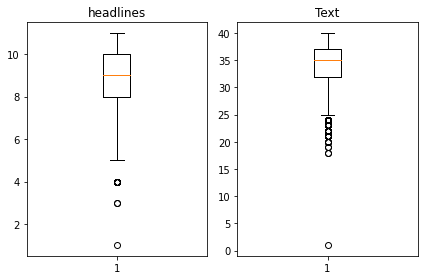

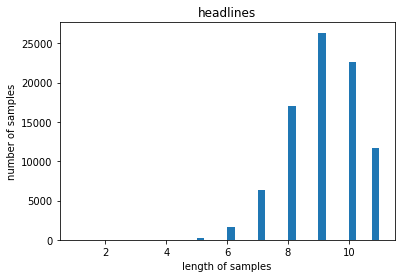

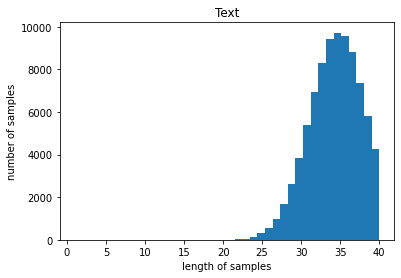

In [40]:
# boxplot을 이용한 IQR 시각화
plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

# 히스토그램 시각화
plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [42]:
# 임의의 max_len 선정
headlines_max_len = 11
text_max_len = 40

below_threshold_len(headlines_max_len,  data['headlines'])
below_threshold_len(text_max_len, data['text'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0


In [43]:
# max_len 길이 이하만 추출
# 98360 -> 85843
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

data.shape

(85843, 2)

### encoder, decoder 데이터 정의

In [44]:
# headline 토큰에는 훈련을 위한 시작 및 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [45]:
# 마지막에 eostoken이 잘 붙었는지 확인
data['decoder_target'][0]

'upgrad learner switches to career in ml al with salary hike eostoken'

In [46]:
# encoder decoder input target 정의
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 데이터 분리

In [47]:
# shuffle을 이용한 데이터 샘플 순서 무작위 정의
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
indices

array([66932, 51225, 60493, ...,  1526, 53297, 17622])

In [48]:
# 테스트 데이터 수 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [49]:
# train, test 데이터 분리
# train 68675개, test 17168개로 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

encoder_input_train.shape, encoder_input_test.shape

((68675,), (17168,))

## 

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [51]:
# 토크나이저 정의 및 단어 집합 생성(train encode 데이터)
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [52]:
# 등장 빈도 수 기준
threshold = 7

# 총 단어 수
total_cnt = len(src_tokenizer.word_index)
# threshold보다 적은 단어 수
rare_cnt = 0
# 단어의 총 빈도 수 및 rare 빈도 수
total_freq = 0
rare_freq = 0


# key: 단어, value: 빈도 수
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면 rare 변수에 추가
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64725
등장 빈도가 6번 이하인 희귀 단어의 수: 44180
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 20545
단어 집합에서 희귀 단어의 비율: 68.25801467748165
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7942437686346677


In [53]:
# 단어 수 : 64672
# 등장 빈도 6회 이하 단어 수 : 44060 (68.12%)
# 7회 이상 : 64672 - 44080 = 20612

# 단어 집합 크기 제한(20000)을 통한 단어 집합 생성
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [54]:
# text to int(정수 시퀀스)
# train test 모두 처리
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [55]:
print(encoder_input_train[:3])

[[551, 1421, 275, 4525, 1448, 98, 18039, 177, 1, 1421, 13622, 99, 119, 11867, 99, 7071, 1775, 34, 231, 1566, 1421, 6317, 13128, 1723, 3030, 4258, 39, 1061, 177, 4, 6, 1070, 1421, 2741, 4945, 3935, 792, 2932, 513, 2064], [1410, 127, 1, 176, 53, 212, 8194, 1712, 4946, 315, 1101, 3802, 8194, 828, 18, 32, 3416, 8025, 10297, 343, 4306, 1059, 1502, 469, 1, 6501, 8194, 253, 3181], [1039, 3350, 1516, 100, 6088, 11152, 5, 42, 798, 94, 878, 13129, 798, 2503, 1554, 127, 464, 45, 28, 45, 3031, 464, 88, 1105, 70, 829, 6149, 823, 1324, 1443, 798, 32, 318, 2202, 692, 464, 296]]


In [56]:
# decoder input에도 같은 순서 반복
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [57]:
def check_vocab_freq(threshold, tokenizer):
    threshold = threshold
    total_cnt = len(tokenizer.word_index)
    rare_cnt = 0
    total_freq = 0
    rare_freq = 0

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tar_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [58]:
# threshold=6일 때
check_vocab_freq(6, tar_tokenizer)

단어 집합(vocabulary)의 크기 : 28478
등장 빈도가 5번 이하인 희귀 단어의 수: 18743
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9735
단어 집합에서 희귀 단어의 비율: 65.81571739588455
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.158000983462305


In [59]:
# threshold=8일 때
check_vocab_freq(8, tar_tokenizer)

단어 집합(vocabulary)의 크기 : 28478
등장 빈도가 7번 이하인 희귀 단어의 수: 20276
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8202
단어 집합에서 희귀 단어의 비율: 71.19882014186389
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.58028301859664


In [60]:
# threshold=8일 때 기준으로 단어 집합 크기 제한
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 753, 8204, 85, 22, 325, 3, 133, 8898, 607, 117], [1, 1370, 1743, 195, 166, 6, 1269], [1, 880, 3989, 3, 1003, 4, 205, 59], [1, 15, 203, 3, 952, 7, 3612, 761], [1, 953, 12, 7110, 5, 9737, 736, 1384, 314, 126]]
target
decoder  [[753, 8204, 85, 22, 325, 3, 133, 8898, 607, 117, 2], [1370, 1743, 195, 166, 6, 1269, 2], [880, 3989, 3, 1003, 4, 205, 59, 2], [15, 203, 3, 952, 7, 3612, 761, 2], [953, 12, 7110, 5, 9737, 736, 1384, 314, 126, 2]]


In [61]:
# headlines의 길이가 0인 경우 추출
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [62]:
#decoder_input_train[drop_train[0]]

In [63]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


In [64]:
# 패딩 -> pre
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')

encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

In [65]:
# 앞에 0으로 패딩이 들어간 모습을 볼 수 있음
encoder_input_train[0]

array([  551,  1421,   275,  4525,  1448,    98, 18039,   177,     1,
        1421, 13622,    99,   119, 11867,    99,  7071,  1775,    34,
         231,  1566,  1421,  6317, 13128,  1723,  3030,  4258,    39,
        1061,   177,     4,     6,  1070,  1421,  2741,  4945,  3935,
         792,  2932,   513,  2064], dtype=int32)

## 모델 설계

In [66]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [67]:
model.compile(
    optimizer='rmsprop',
    loss = 'sparse_categorical_crossentropy'
)

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    ],
    epochs=50
)

Epoch 1/50
269/269 [==============================] - 31s 92ms/step - loss: 5.9836 - val_loss: 5.6087
Epoch 2/50
269/269 [==============================] - 24s 90ms/step - loss: 5.6326 - val_loss: 5.4962
Epoch 3/50
269/269 [==============================] - 25s 91ms/step - loss: 5.4944 - val_loss: 5.2960
Epoch 4/50
269/269 [==============================] - 24s 89ms/step - loss: 5.2326 - val_loss: 5.0547
Epoch 5/50
269/269 [==============================] - 24s 89ms/step - loss: 4.9662 - val_loss: 4.8363
Epoch 6/50
269/269 [==============================] - 24s 91ms/step - loss: 4.7421 - val_loss: 4.8849
Epoch 7/50
269/269 [==============================] - 24s 90ms/step - loss: 4.5623 - val_loss: 4.5605
Epoch 8/50
269/269 [==============================] - 24s 90ms/step - loss: 4.3891 - val_loss: 4.4363
Epoch 9/50
269/269 [==============================] - 24s 90ms/step - loss: 4.2277 - val_loss: 4.3516
Epoch 10/50
269/269 [==============================] - 24s 90ms/step - loss: 4.081

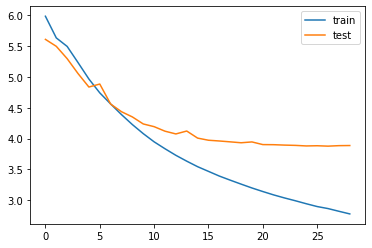

In [68]:
# loss 확인
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현

In [69]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word
# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index 
# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 

In [70]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트

In [78]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
         if (i>2):
            temp = temp + tar_index_to_word[i]+' '
    return temp.strip()

In [79]:
len(encoder_input_test)

17168

In [80]:
seq2summary(decoder_input_test[51])

'mia by celebrates your unique'

In [81]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : year old pune based woman suspected suicide bomber detained jammu kashmir police thursday night alert earlier issued warning non kashmiri woman may attempt suicide attack republic day woman questioned anti terrorism squad alleged isis connections sent programme 
실제 요약 : suspected female suicide bomber held in jammu and kashmir
예측 요약 :  woman shoots self after being shoots self at delhi woman


원문 : presenting mia latest collection celebrates unique traits women difference women bring lives work things unique way explore crystal encrusted range earrings rings make rise shine 
실제 요약 : mia by celebrates your unique
예측 요약 :  women should be taught women to wear sarees in women


원문 : firecracker traders delhi ncr moved supreme court wednesday seeking permission sell stock comes court monday banned sale firecrackers region till november order check alarming pollution level traders told court licences banned november last year got revived september 
실제 요약 : delhi firecracker traders see

## summa를 활용한 추출적 요약 시도

In [76]:
from summa.summarizer import summarize

In [77]:
data_origin = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [89]:
data_origin.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [86]:
summarize(data_origin.loc[0,'text'], words=10)

"upGrad's Online Power Learning has powered 3 lakh+ careers."

In [105]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [125]:
# data_origin에 존재하는 text를 summarize를 통해 추출적 요약 시도
# 해당 요약은 data의 summa로 추가
for i in tqdm(data.index):
    data.loc[i,'summa'] = summarize(data_origin.loc[i, 'text'], words=10)

100%|██████████| 85843/85843 [03:25<00:00, 416.80it/s]


In [126]:
data.head()

,headlines,text,decoder_input,decoder_target,summa
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...,upGrad's Online Power Learning has powered 3 l...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...,The match witnessed India getting all out for ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...,
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...,
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...,


In [203]:
data.index

Int64Index([    0,     2,     3,     5,     7,     8,     9,    10,    14,
               15,
            ...
            98390, 98391, 98392, 98393, 98394, 98395, 98396, 98397, 98398,
            98400],
           dtype='int64', length=85843)

In [223]:
data_origin.loc[2,'text']

"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history."

In [235]:
summarize(data_origin.loc[2,'text'], words=10)

'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.'

In [236]:
# seq2summary(decoder_input_test)를 통해 나온 문장이 decoder_input에 존재하거나
# summa가 존재하는 경우, data_origin에서의 실제 원문과 summa 요약을 추가 print
for i in range(0, 100):
    index_query = data[data['decoder_input'].str.contains(seq2summary(decoder_input_test[i]))]
    if len(index_query) ==0: continue
    if data.loc[index_query.index[0], 'summa'] == '': continue
    
    print("실제 원문 :", data_origin.loc[index_query.index[0], 'text'])
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("summa 요약 :", data.loc[index_query.index[0], 'summa'])
    print("\n")

실제 원문 : PM Narendra Modi's decision to walk throughout late PM Atal Bihari Vajpayee's funeral procession from BJP headquarters to Rashtriya Smriti Sthal was a surprise, a security official has said. "We got very little time to tweak his security plan," he added. Security protocol requires the area to be cordoned off hours before a Prime Minister drives past a road.
원문 : pm narendra modi decision walk throughout late pm atal bihari vajpayee funeral procession bjp headquarters rashtriya smriti surprise security official said got little time security plan added security protocol requires area cordoned hours prime minister drives past road 
실제 요약 : pm modi walking in atal procession was surprise security
예측 요약 :  pm modi prez kovind extend greetings on late pm vajpayee
summa 요약 : "We got very little time to tweak his security plan," he added.


실제 원문 : According to reports, Facebook is working on a laptop-sized video chat device that will allow users to feel like they're in the same room. 

## 결과

### 비교
- 추상적 요약
    - 다양한 단어가 나옴
    - 연관 없는 단어도 나오는 경우가 존재
    - 문장의 완성도는 떨어지는 듯 함
    - 핵심단어가 존재하지만 아닌 경우는 비슷한 단어로 대체하는 것처럼 보임
- 추출적 요약
    - Summarize는 원문의 길이가 적으면 요약이 안되는 듯 함
    - 중요 문장을 최대한 그대로 가져오므로 문장의 완성도는 높게 나오는 듯 함
    - 문장 그대로 가져오는 것 때문에 보통은 핵심단어가 포함되는 듯 함